In [10]:
import os
for dirname, _, filenames in os.walk('/home/piai/AI_Pytorch/posco-aibd/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/home/piai/AI_Pytorch/posco-aibd/test.csv
/home/piai/AI_Pytorch/posco-aibd/train.csv


In [11]:
# ============================== Do not edit this shell ==========================================

# Dataset Definition

import csv
import numpy as np
import pandas as pd
import torch
from PIL import Image
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset

class CharDataset(Dataset):
    def __init__(self, root, train, transform=None):
        self.train = train
        if self.train:
            root = root + 'train.csv'
        else:
            root = root + 'test.csv'
        self.csv = pd.read_csv(root, header=None)
        self.transform = transform
        
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, index):
        if self.train:
            label = torch.tensor(self.csv.iloc[index,0], dtype=torch.long)
            img = np.array(self.csv.iloc[index,1:]/255).reshape(28, 28)
            img = Image.fromarray(img)
            if self.transform:
                img = self.transform(img)
            return img, label
        else:
            img = np.array(self.csv.loc[index]/255).reshape(28, 28)
            img = Image.fromarray(img)
            if self.transform:
                img = self.transform(img)
            return img
        
# ============================== Do not edit this shell ==========================================

In [12]:
# Library Importation
import gc
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from IPython.display import clear_output
from skimage.transform import resize as OVResize
from torch.cuda import memory_allocated, empty_cache
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, random_split
from torchsummary import summary as Summary
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip, \
                                   ToPILImage, Resize, Grayscale
# Hyper Parameter
## Data Loader
batch_size = 23

# ## Model
# hidden_layer = 300

## Learning
logging_dispfig = True
maximum_epoch = 100
learning_rate = 0.005

# Device Preparation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{"CPU" if device == "cpu" else "GPU"} will be used in training/validation.')

GPU will be used in training/validation.


===================== Check the data =========================

Train dataset length = 13481
Valid dataset length = 1498
Test dataset length = 3745

Content of Y (Label, type=<class 'torch.Tensor'>) = 6
Shape of X (Data, type=<class 'torch.Tensor'>) = torch.Size([1, 28, 28])


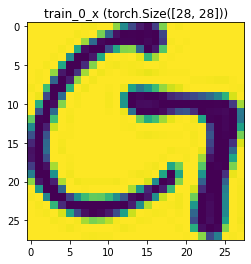

================== Check the data loader ======================

Idx: 0 / X.shape = torch.Size([23, 1, 28, 28]) / Y.shape = torch.Size([23])

Y[0:23] = tensor([7, 7, 8, 0, 2, 1, 7, 4, 2, 7, 9, 6, 3, 5, 8, 7, 1, 6, 0, 4, 8, 6, 1])


In [13]:
# Prepare dataset
root = '/home/piai/AI_Pytorch/posco-aibd/'
train_data = CharDataset(root, train=True, transform=ToTensor())
train_data, valid_data = random_split(train_data, [round(len(train_data)*0.9), round(len(train_data)*0.1)])
test_data = CharDataset(root, train=False, transform=ToTensor())

# Check the data
print('===================== Check the data =========================\n')
print(f'Train dataset length = {len(train_data)}')
print(f'Valid dataset length = {len(valid_data)}')
print(f'Test dataset length = {len(test_data)}\n')

train_0_x, train_0_y = train_data[0]
print(f'Content of Y (Label, type={type(train_0_y)}) = {train_0_y}')
print(f'Shape of X (Data, type={type(train_0_x)}) = {train_0_x.shape}')
plt.figure(1)
plt.imshow(train_0_x.squeeze())
plt.title(f'train_0_x ({train_0_x.squeeze().shape})')
plt.show()

# Create data loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=len(valid_data), pin_memory=True)
test_loader = DataLoader(test_data, batch_size=len(test_data), pin_memory=True)

# Examine the data loader
print('================== Check the data loader ======================\n')
train_enumerator = enumerate(train_loader)
ex_batch_idx, (ex_data, ex_label) = next(train_enumerator)
print(f'Idx: {ex_batch_idx} / X.shape = {ex_data.shape} / Y.shape = {ex_label.shape}\n')
print(f'Y[0:{batch_size}] = {ex_label}')
preview_index = 0

### ResNet 구현

In [14]:
def init_model():
    global net, loss_fn, optim
    net = ResNet().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr=learning_rate)

In [15]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 32
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(32, 1, stride=1)
        self.layer2 = self._make_layer(64, 1, stride=2)
        self.layer3 = self._make_layer(128, 1, stride=2)
        self.layer4 = self._make_layer(256, 1, stride=2)
        self.linear = nn.Linear(256, num_classes)
    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

Summary(ResNet().to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             288
       BatchNorm2d-2           [-1, 32, 28, 28]              64
            Conv2d-3           [-1, 32, 28, 28]           9,216
       BatchNorm2d-4           [-1, 32, 28, 28]              64
            Conv2d-5           [-1, 32, 28, 28]           9,216
       BatchNorm2d-6           [-1, 32, 28, 28]              64
        BasicBlock-7           [-1, 32, 28, 28]               0
            Conv2d-8           [-1, 64, 14, 14]          18,432
       BatchNorm2d-9           [-1, 64, 14, 14]             128
           Conv2d-10           [-1, 64, 14, 14]          36,864
      BatchNorm2d-11           [-1, 64, 14, 14]             128
           Conv2d-12           [-1, 64, 14, 14]           2,048
      BatchNorm2d-13           [-1, 64, 14, 14]             128
       BasicBlock-14           [-1, 64,

In [16]:
# Memory cleaner to prevent CUDA out of memory error
def clear_memory():
    if device != 'cpu':
        empty_cache()
    gc.collect()

def init_epoch():
  global epoch_cnt
  epoch_cnt = 0

# Epoch (similar to day 2)

  
def epoch(data_loader):
  # One epoch : gets data_loader as input and returns loss / accuracy, and
  #             last prediction value / its label(truth) value for future use
  global epoch_cnt
  iter_loss, iter_acc = [], []
  
  last_grad_performed = False
  
  # Mini-batch iterations
  for _data, _label in data_loader:
    data, label = _data.to(device), _label.to(device)
    
    # 1. Feed-forward
    onehot_out = net(data)
    
    # 2. Calculate accuracy
    _, out = torch.max(onehot_out, 1)
    acc_partial = (out == label).float().sum()
    acc_partial = acc_partial / len(label)
    iter_acc.append(acc_partial.item())
    
    # 3. Calculate loss
    loss = loss_fn(onehot_out, label)
    iter_loss.append(loss.item())
    
    # 4. Backward propagation if not in `torch.no_grad()`
    if onehot_out.requires_grad:
      optim.zero_grad()
      loss.backward()
      optim.step()
      last_grad_performed = True
      
  # Up epoch count if backward propagation is done
  if last_grad_performed:
    epoch_cnt += 1
    
  # Clear memory to prevent CUDA memory error
  clear_memory()
    
  return np.average(iter_loss), np.average(iter_acc)


def epoch_not_finished():
  # For now, let's repeat training fixed times, e.g. 25 times.
  # We will learn how to determine training stop or continue later.
  return epoch_cnt < maximum_epoch

# Logging
def init_log():
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    time_log, log_stack = [], []
  
  
def record_train_log(_tloss, _tacc, _time):
    # Push time, training loss, training accuracy, and epoch count into lists
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)
  
  
def record_valid_log(_vloss, _vacc):
    # Push validation loss and validation accuracy into each list
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)

    
def last(log_list):
    # Get the last member of list. If empty, return -1.
    if len(log_list) > 0: return log_list[len(log_list) - 1]
    else: return -1


def print_log():
    # Generate log string and put it into log stack
    log_str = f'Iter: {last(iter_log):>4d} >> T_loss {last(tloss_log):<8.5f}   ' \
          + f'T_acc {last(tacc_log):<6.5f}   V_loss {last(vloss_log):<8.5f}   ' \
          + f'V_acc {last(vacc_log):<6.5f}   🕒 {last(time_log):5.3f}s'
    log_stack.append(log_str)
  
  # Draw figure if want
    if logging_dispfig:
        hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99)
        hist_fig.patch.set_facecolor('white')

        # Draw loss lines
        loss_t_line = plt.plot(iter_log, tloss_log, label='Train Loss', color='#FF9999', marker='o')
        loss_v_line = plt.plot(iter_log, vloss_log, label='Valid Loss', color='#99B0FF', marker='s')
        loss_axis.set_xlabel('epoch')
        loss_axis.set_ylabel('loss')

        # Draw accuracy lines
        acc_axis = loss_axis.twinx()
        acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train Acc.', color='#FF0000', marker='+')
        acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid Acc.', color='#003AFF', marker='x')
        acc_axis.set_ylabel('accuracy')

        # Append annotations
        hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line
        loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines])
        loss_axis.grid()
        plt.title(f'Learning history until epoch {last(iter_log)}')
        plt.draw()
    
  # Print log
    clear_output(wait=True)
    if logging_dispfig: plt.show()
    for idx in reversed(range(len(log_stack))):
        print(log_stack[idx])

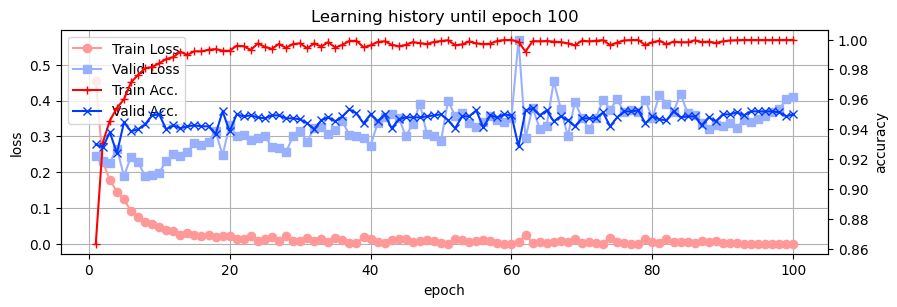

Iter:  100 >> T_loss 0.00051    T_acc 0.99970   V_loss 0.41117    V_acc 0.94993   🕒 13.046s
Iter:   99 >> T_loss 0.00049    T_acc 0.99978   V_loss 0.40332    V_acc 0.94860   🕒 13.212s
Iter:   98 >> T_loss 0.00049    T_acc 0.99970   V_loss 0.37568    V_acc 0.95127   🕒 11.524s
Iter:   97 >> T_loss 0.00050    T_acc 0.99970   V_loss 0.36904    V_acc 0.95194   🕒 13.169s
Iter:   96 >> T_loss 0.00050    T_acc 0.99970   V_loss 0.35599    V_acc 0.95194   🕒 13.146s
Iter:   95 >> T_loss 0.00051    T_acc 0.99970   V_loss 0.34730    V_acc 0.95194   🕒 13.143s
Iter:   94 >> T_loss 0.00052    T_acc 0.99970   V_loss 0.34032    V_acc 0.95194   🕒 12.903s
Iter:   93 >> T_loss 0.00058    T_acc 0.99978   V_loss 0.34681    V_acc 0.94927   🕒 13.132s
Iter:   92 >> T_loss 0.00166    T_acc 0.99955   V_loss 0.32434    V_acc 0.95127   🕒 13.124s
Iter:   91 >> T_loss 0.00228    T_acc 0.99941   V_loss 0.33734    V_acc 0.94993   🕒 13.131s
Iter:   90 >> T_loss 0.00353    T_acc 0.99881   V_loss 0.32958    V_acc 0.94993 

In [17]:
# Training Initialization
init_model()
init_epoch()
init_log()

# Training Iteration
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc = epoch(train_loader)
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc = epoch(valid_loader)
        record_valid_log(vloss, vacc)
    print_log()
    
print('\n Training completed!')

In [9]:
# Save prediction vector to CSV file

# Before run this code, here put your save path (only for local server not kaggle kernel)
save_root = './test_pred_final.csv'   # <--- only edit this path

# After run this code, you must check that the shape of 'out' variable is 3745. (out.shape == 3745)


# ============================== Do not edit under this line ==========================================
for _data in test_loader:
    data = _data.to(device)

    # 1. Feed-forward
    onehot_out = net(data)
    _, out = torch.max(onehot_out, 1)
    
print(out.shape)

import csv

# 덮어쓰기 방지를 위해 이미 파일이 존재하면 삭제
if os.path.isfile(save_root):
    os.remove(save_root)

# 첫 행에 'id' 'lable' 그 다음 행부터 idx와 label 넣어서 csv 저장
for idx, pred in enumerate(list(out.cpu())):
    with open(save_root, 'a', newline='') as f:
        writer = csv.writer(f)
        if idx == 0:
            writer.writerow(['id', 'label'])
        pred = np.concatenate(([idx], [pred]))
        writer.writerow(pred)
# ============================== Do not edit over this line ==========================================

NameError: name 'net' is not defined